
- Dataset downloaded from Kaggle
- upload to drive in unzip

In [ ]:
# unzip compress image files for initial upload to drive
# !unzip "/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/archive (4).zip" -d "/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships"

In [ ]:
# import all files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import datasets handling
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler

# visualize
from sklearn.decomposition import PCA

# LBP
from skimage import feature

# model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# splitting datasets
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import classification_report,accuracy_score

# plotting
import matplotlib.pyplot as plt

# hog
from skimage.feature import hog

In [ ]:
# read image dataset from google drive, then return X and Y dataset
def read_images(path):

  # List all files in the folder check number of files exist in that path
  files = os.listdir(path_dtset)
  print(f"Number of images in the folder: {len(files)}")

  # prepare x and y container to store actual images and labels
  # labels are noted in image name || e.g 0_.jpg -> ships not present.
  X = []
  Y = []
  # iterate each images and add them to array
  for image_file_name in files:
    img = cv2.imread(path_dtset + '/' +str(image_file_name), 0)
    X.append(img)
    if str(image_file_name[0]) == "0" :
      Y.append(0)
    else :
      Y.append(1)

  # convert array to numpy array type for easier manipulation in models
  X = np.array(X)
  Y = np.array(Y)

  # verify correctness on X and Y
  print("x dataset type :",type(X))
  print("y dataset type",type(Y))
  print(" shape X :",X.shape," shape Y :",Y.shape)

  return X, Y

# pick 1 image from dataset and show with its label
def show_image_with_label(image, label):

    # Display the image
    plt.imshow(image, cmap='gray')  # Assuming the image is grayscale
    plt.title(f'Label: {label}')

    # Show plot
    plt.show()

# normalize input pixel values for improving description
def normalize_pixelvalues(X):

  # normalize all pixel values in [0,255]
  X = X/255.0

  # validate normalization
  print(f"Minimum value: {np.min(X)}")
  print(f"Maximum value: {np.max(X)}")

  return X

# get lbp representation of images dataset
def get_lbp(X,numPoints,radius):

  # list to store extracted features of an image
  lbp_features = []

  # iterate images
  for image in X:

    # return 2d array of our image applied with lbp
    lbp = feature.local_binary_pattern(image, numPoints,radius)#,method="uniform")

    # return feature vector(histogram)
    (hist, _) = np.histogram(lbp.ravel())#  bins=np.arange(0, numPoints + 3),range=(0, numPoints + 2))

    # normalize each  histogram
    eps = 1e-7
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    #a add normalize histogram to lbp_features list
    lbp_features.append(hist)


  # return all lbp representation of images'
  return lbp_features
# -- notes --
# histogram is a representation of the texture characteristics
# 2 images have same distribution in hist, if their texture look alike. e.g. dots

# plot histogram of lbp for single sample image to verify correctness
def plot_lbp(lbp_feature_vector, ax):
    # Plotting a histogram
    ax.hist(lbp_feature_vector, color='skyblue', edgecolor='black')
    ax.set_title('LBP Feature Vector')
    ax.set_xlabel('LBP Values')
    ax.set_ylabel('Frequency')

# generat train test set
def generate_train_test(X,Y,test_size):
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y,test_size=test_size,shuffle=True)
    print("x train shape", len(xtrain))
    print("y test shape", len(ytest))
    print("take 1st sample from x train", xtrain[0])
    print("take 1st sample from y test", ytest[0])

    return xtrain, xtest, ytrain, ytest

# generate hog version of X image dataset and return
def hog_features(X, pixels_per_cell,cells_per_block):
    # a list to store feature vector for each images
    feature_vector_list = []
    # store hog applied image
    hog_img_list = []

    # iterate thru each images
    for image in X:
      # generate hog vector and hog 2d image array for each images
      fv, hog_img = hog(image, orientations=9, pixels_per_cell=pixels_per_cell,visualize=True,block_norm='L2')
      feature_vector_list.append(fv)
      hog_img_list.append(hog_img)

    # return a list of feature vectors and 2d array
    return np.array(feature_vector_list), hog_img_list
# notes
# counts occurrences of gradient orientation in the localized portion of an image
# Gradient orientation refers to the direction in which the intensity or color of an image changes most rapidly at a particular point.
# e.g. in our case ship towards top right, 45 degree has the most

In [ ]:
# for plotting results

def plot_hog_features_vectors(hog_feature1, hog_feature2, hog_feature3, hog_feature4):
    fig, axs = plt.subplots(1, 4, figsize=(15, 3))  # Adjust the figsize as needed

    # Plot for the first HOG feature
    axs[0].scatter(range(len(hog_feature1)), hog_feature1, color='red')
    axs[0].set_title('HOG Feature 1')

    # Plot for the second HOG feature
    axs[1].scatter(range(len(hog_feature2)), hog_feature2, color='blue')
    axs[1].set_title('HOG Feature 2')

    # Plot for the third HOG feature
    axs[2].scatter(range(len(hog_feature3)), hog_feature3, color='green')
    axs[2].set_title('HOG Feature 3')

    # Plot for the fourth HOG feature
    axs[3].scatter(range(len(hog_feature4)), hog_feature4, color='purple')
    axs[3].set_title('HOG Feature 4')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
   x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
   x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
   xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
   np.arange(x2_min, x2_max, resolution))
   Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
   Z = Z.reshape(xx1.shape)
   plt.contourf(xx1, xx2, Z, 100, alpha=0.15, cmap = 'bwr')
   plt.xlim(xx1.min(), xx1.max())
   plt.ylim(xx2.min(), xx2.max())

In [ ]:
# returns X: set of images where each image size  80 x 80
# Y : 1d array of ones/zeros
path_dtset = '/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships/shipsnet/shipsnet'
X, Y = read_images(path_dtset)

Number of images in the folder: 4000
x dataset type : <class 'numpy.ndarray'>
y dataset type <class 'numpy.ndarray'>
 shape X : (4000, 80, 80)  shape Y : (4000,)


In [ ]:
X = normalize_pixelvalues(X)

Minimum value: 0.00392156862745098
Maximum value: 1.0


# LBP fit

## Visualize

Text(0.5, 1.0, '4.Label: 1')

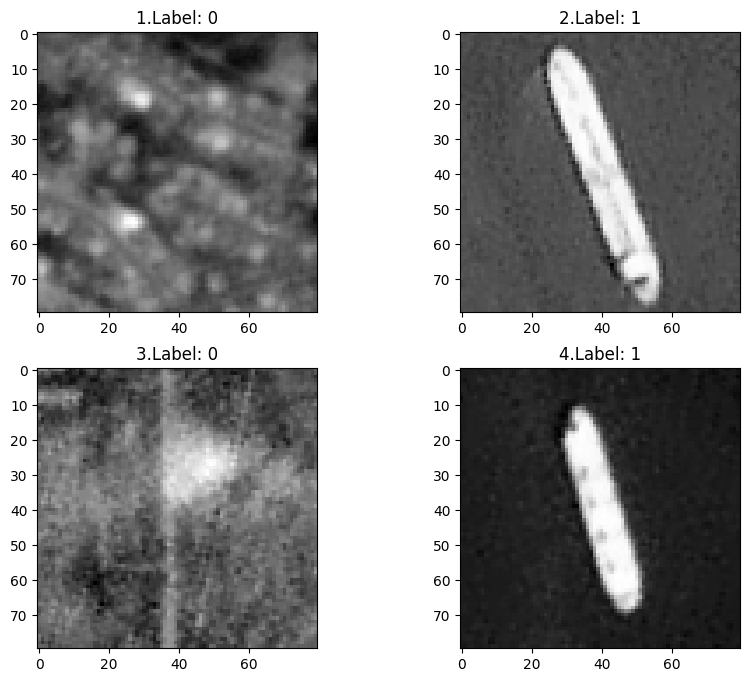

In [ ]:
# Choose the index of the image you want to display
index_to_display_1 = 3901
index_to_display_2 = 100
index_to_display_3 = 3907
index_to_display_4 = 902

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Show images with labels in each subplot
axs[0, 0].imshow(X[index_to_display_1], cmap='gray')
axs[0, 0].set_title(f'1.Label: {Y[index_to_display_1]}')
axs[0, 1].imshow(X[index_to_display_2], cmap='gray')
axs[0, 1].set_title(f'2.Label: {Y[index_to_display_2]}')
axs[1, 0].imshow(X[index_to_display_3], cmap='gray')
axs[1, 0].set_title(f'3.Label: {Y[index_to_display_3]}')
axs[1, 1].imshow(X[index_to_display_4], cmap='gray')
axs[1, 1].set_title(f'4.Label: {Y[index_to_display_4]}')

In [ ]:
# get lbp representation x dataset images
lbp_X = get_lbp(X,numPoints=8,radius=1)

we see 2nd and 4th have a bit similar pattern.


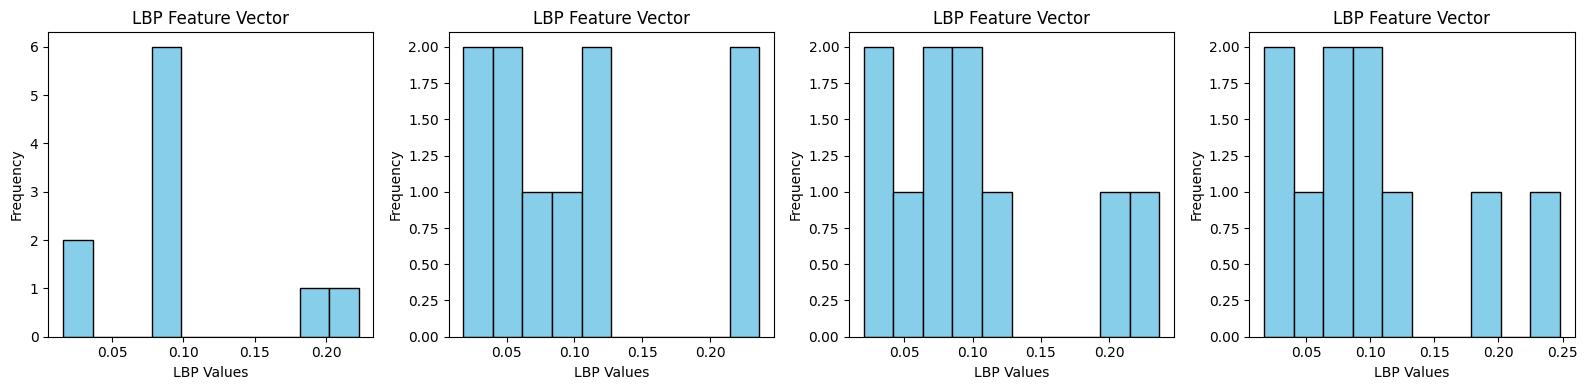

In [ ]:
# verify lbp feature correctness

# Plot LBP features in each subplot
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot LBP feature vectors in each subplot
plot_lbp(lbp_X[index_to_display_1], axs[0])
plot_lbp(lbp_X[index_to_display_2], axs[1])
plot_lbp(lbp_X[index_to_display_3], axs[2])
plot_lbp(lbp_X[index_to_display_4], axs[3])

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

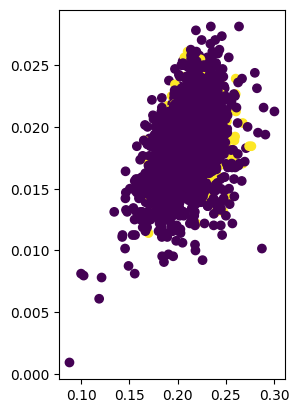

In [ ]:
# Extract all rows from the first column
all_lbp_first_row = lbp_X_sample[:, 0]
all_lbp_seconds_row = lbp_X_sample[:, 6]
plt.subplot(1, 2, 1)
plt.scatter(all_lbp_first_row, all_lbp_seconds_row, c=Y, cmap='viridis')

In [ ]:
lbp_X = np.array(lbp_X)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(lbp_X)

In [ ]:
lbp_xtrain, lbp_xtest, lbp_ytrain, lbp_ytest = generate_train_test(lbp_X,Y,test_size=0.2)

x train shape 3200
y test shape 800
take 1st sample from x train [0.204375   0.0578125  0.0990625  0.02578125 0.11890625 0.088125
 0.01734375 0.10578125 0.05171875 0.23109375]
take 1st sample from y test 0


## PCA

Text(0, 0.5, 'PC3')

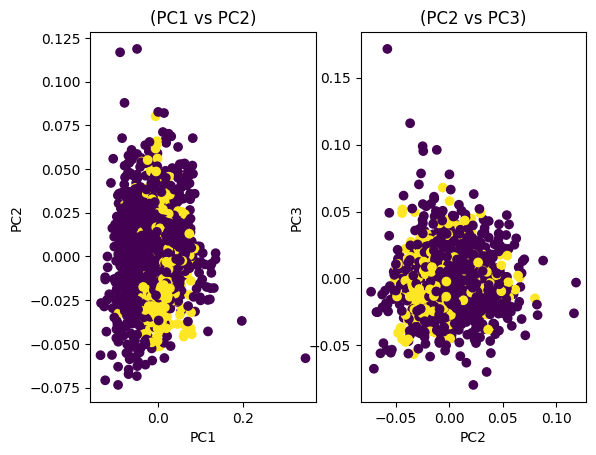

In [ ]:
# Use PCA for dimensionality reduction to 3D
pca = PCA(n_components=3)
lbp_features_pca = pca.fit_transform(lbp_xtrain)

# Plot the first subplot (PC1 vs PC2)
plt.subplot(1, 2, 1)
plt.scatter(lbp_features_pca[:, 0], lbp_features_pca[:, 1], c=lbp_ytrain, cmap='viridis')
plt.title('(PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot the second subplot (PC2 vs PC3)
plt.subplot(1, 2, 2)
plt.scatter(lbp_features_pca[:, 1], lbp_features_pca[:, 2], c=lbp_ytrain, cmap='viridis')
plt.title('(PC2 vs PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')

## fit

In [ ]:
# define linear svc model
model =  SVC(kernel='poly',C=0.9,max_iter=1000)
model.fit(lbp_xtrain, lbp_ytrain)

# do a prediction
lbp_y_pred = model.predict(lbp_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(lbp_ytest, lbp_y_pred)))
print('\n')
print(classification_report(lbp_ytest, lbp_y_pred))

LBP Accuracy: 0.7525


              precision    recall  f1-score   support

           0       0.76      0.99      0.86       605
           1       0.20      0.01      0.01       195

    accuracy                           0.75       800
   macro avg       0.48      0.50      0.43       800
weighted avg       0.62      0.75      0.65       800



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
# define LogisticRegression model
lg_model = LogisticRegression(C=0.9,max_iter=1000)
lg_model.fit(lbp_xtrain, lbp_ytrain)

# do a prediction
lbp_y_pred = lg_model.predict(lbp_xtest)

# get accuracy on test set of lbp
print("LBP Accuracy: "+str(accuracy_score(lbp_ytest, lbp_y_pred)))
print('\n')
print(classification_report(lbp_ytest, lbp_y_pred))

LBP Accuracy: 0.75625


              precision    recall  f1-score   support

           0       0.76      1.00      0.86       605
           1       0.00      0.00      0.00       195

    accuracy                           0.76       800
   macro avg       0.38      0.50      0.43       800
weighted avg       0.57      0.76      0.65       800



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# define MLPClassifier
# we have 10 features from lbp feature vectors, thus inputs are size 10
est = MLPClassifier(hidden_layer_sizes=(10,10),activation='relu')

# fit model on lbp datasets
est.fit(lbp_xtrain, lbp_ytrain)
lbp_y_pred = est.predict(lbp_xtest)
print(accuracy_score(lbp_ytest,lbp_y_pred))

# get accuracy on test set of lbp
print("LBP Accuracy: "+str(accuracy_score(lbp_ytest, lbp_y_pred)))
print('\n')
print(classification_report(lbp_ytest, lbp_y_pred))

0.75375
LBP Accuracy: 0.75375


              precision    recall  f1-score   support

           0       0.76      1.00      0.86       605
           1       0.25      0.01      0.01       195

    accuracy                           0.75       800
   macro avg       0.50      0.50      0.43       800
weighted avg       0.63      0.75      0.65       800



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# HOG fit

## Visualize

In [ ]:
X.shape

(4000, 80, 80)

Text(0.5, 1.0, '4.Label: 1')

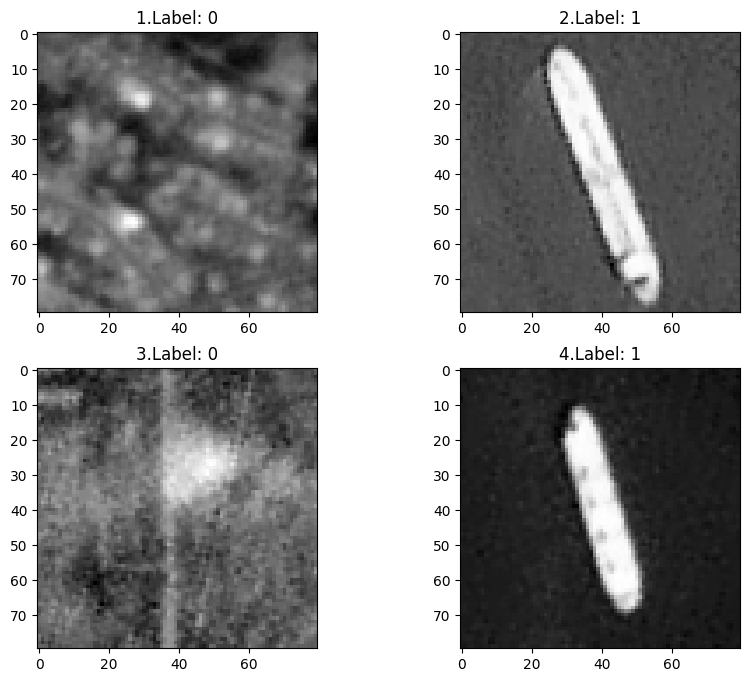

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# Show images with labels in each subplot
axs[0, 0].imshow(X[index_to_display_1], cmap='gray')
axs[0, 0].set_title(f'1.Label: {Y[index_to_display_1]}')
axs[0, 1].imshow(X[index_to_display_2], cmap='gray')
axs[0, 1].set_title(f'2.Label: {Y[index_to_display_2]}')
axs[1, 0].imshow(X[index_to_display_3], cmap='gray')
axs[1, 0].set_title(f'3.Label: {Y[index_to_display_3]}')
axs[1, 1].imshow(X[index_to_display_4], cmap='gray')
axs[1, 1].set_title(f'4.Label: {Y[index_to_display_4]}')

In [ ]:
#
pixels_per_cell = (8,8)
cells_per_block = (2,2)

# return a list of feature vectors and 2d array
hog_x, hog_images_2d_arr = hog_features(X, pixels_per_cell,cells_per_block)

In [ ]:
hog_x.shape

(4000, 5184)

In [ ]:
hog_x[index_to_display_2].shape

(5184,)

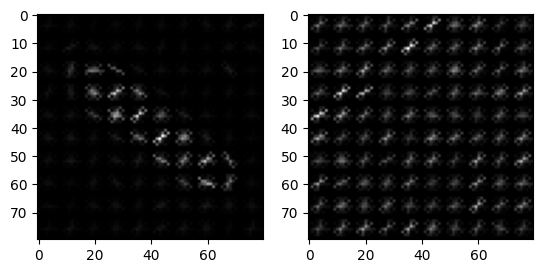

In [ ]:
index_to_display_h1 = 900
index_to_display_h2 = 1000

plt.subplot(121)
plt.imshow(hog_images_2d_arr[index_to_display_h1], cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(hog_images_2d_arr[index_to_display_h2], cmap=plt.cm.gray)

(array([2.027e+03, 1.881e+03, 8.570e+02, 2.770e+02, 8.200e+01, 3.400e+01,
        1.300e+01, 5.000e+00, 6.000e+00, 2.000e+00]),
 array([0.        , 0.06094638, 0.12189276, 0.18283914, 0.24378552,
        0.3047319 , 0.36567828, 0.42662466, 0.48757104, 0.54851742,
        0.6094638 ]),
 <BarContainer object of 10 artists>)

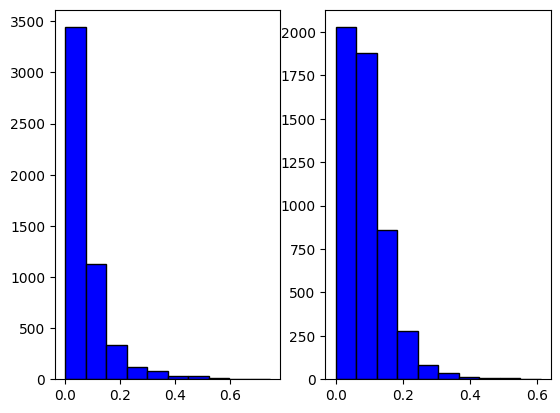

In [ ]:
plt.subplot(121)
plt.hist(hog_x[index_to_display_h1], color='blue', edgecolor='black')
plt.subplot(122)
plt.hist(hog_x[index_to_display_h2], color='blue', edgecolor='black')

In [ ]:
# generat train test set
hog_xtrain, hog_xtest, hog_ytrain, hog_ytest =  generate_train_test(hog_x,Y,test_size=0.2)

x train shape 3200
y test shape 800
take 1st sample from x train [0.06051943 0.16647061 0.06666692 ... 0.00962922 0.03971934 0.04768324]
take 1st sample from y test 1


In [ ]:
hog_xtrain.shape

(3200, 5184)

## PCA
1. purpose here is to grasp the idea how SVC will create the best fitted hyperplane in a 5184 dimensions of hog features.

2. Taking PCA of 3 components, means we take 3 most important hog feature elements.

  - PCA1 and PCA2 are one of the elements.
  - these 2 elements plays a big role in distinguish noship/ship as we can in PC1 vs PC2 plot where yellow/ purple refer to each classes.  


Text(0, 0.5, 'PC3')

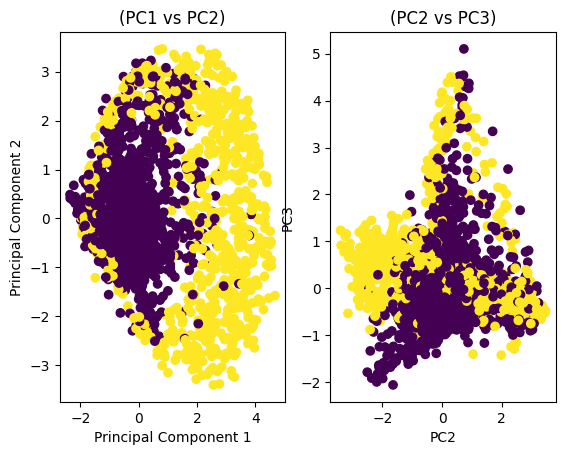

In [ ]:
# Use PCA for dimensionality reduction to 3D
pca = PCA(n_components=3)
hog_features_pca = pca.fit_transform(hog_xtrain)

# Plot the first subplot (PC1 vs PC2)
plt.subplot(1, 2, 1)
plt.scatter(hog_features_pca[:, 0], hog_features_pca[:, 1], c=hog_ytrain, cmap='viridis')
plt.title('(PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the second subplot (PC2 vs PC3)
plt.subplot(1, 2, 2)
plt.scatter(hog_features_pca[:, 1], hog_features_pca[:, 2], c=hog_ytrain, cmap='viridis')
plt.title('(PC2 vs PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')

In [ ]:
# get actual computed pca values with 3 componets
hog_features_pca

array([[ 0.0497748 ,  0.42266366, -0.30819087],
       [-0.26113478,  0.411926  , -0.39202105],
       [ 0.1179924 ,  0.49310493, -0.54665165],
       ...,
       [-1.08377187, -0.31603652, -0.76486259],
       [-0.50696258, -0.33243736, -1.09631596],
       [ 1.72942126,  3.19221556, -0.43809834]])

In [ ]:
pca.explained_variance_ratio_

array([0.08735345, 0.04806938, 0.03027496])

## Fit

In [ ]:
# define linear svc model
hog_svc =  SVC(kernel='poly',C=0.9,max_iter=1000)
hog_svc.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = hog_svc.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


LBP Accuracy: 0.99125


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       596
           1       0.99      0.98      0.98       204

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [ ]:
# define LogisticRegression model
model = LogisticRegression(C=0.9,max_iter=1000)

model.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = model.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

LBP Accuracy: 0.985


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.98      0.97      0.97       204

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [ ]:
# define MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(10,10),activation='relu')

# fit model
model.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = model.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

LBP Accuracy: 0.985


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.98      0.97      0.97       204

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



result hog

# Additional : CNN

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, AveragePooling2D
from keras import backend as K

In [ ]:
# Define a network as a linear stack of layers
model = Sequential()

# Add 1st convolutional layer with:
    # - features maps: 6
    # - kernel shape: 5 x 5
    # - activation function post-convolution: hyperbolic tanget (tanh)
model.add(Conv2D(filters=6,kernel_size=(5,5),
                activation='tanh',
                input_shape=(80,80,1)))

# Add 1st pooling layer with kernel shape: 2 x 2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Add 2st convolutional layer with:
    # - features maps: 16
    # - kernel shape: 5 x 5
    # - activation function post-convolution: hyperbolic tanget (tanh)
model.add(Conv2D(filters=16,kernel_size=(5,5),
                activation='tanh'))

# Add 2st pooling layer with kernel shape: 2 x 2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add 1st fully-connected layer with sigmoid activation function
model.add(Dense(120, activation='sigmoid'))

# Add 2st fully-connected layer with sigmoid activation function
model.add(Dense(84, activation='sigmoid'))

# Add output layer with softmax activation with 10 output classes
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 76, 76, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 38, 38, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 17, 17, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 4624)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
# optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

In [ ]:
import cv2
import os
path_dtset = '/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships/shipsnet/shipsnet'

files = os.listdir(path_dtset)

X = []
Y = []
for image_file_name in files:
  img = cv2.imread(path_dtset + '/' +str(image_file_name), 0)
  X.append(img)
  if str(image_file_name[0]) == "0" :
    Y.append(0)
  else :
    Y.append(1)

In [ ]:
X = np.array(X)
Y = np.array(Y)

X = X/255

In [ ]:
X.shape

(4000, 80, 80)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y,test_size=.20,shuffle=True)

In [ ]:
xtrain.shape, xtest.shape

((3200, 80, 80), (800, 80, 80))

In [ ]:
history = model.fit(xtrain, ytrain, batch_size = 128 ,epochs = 100 , validation_data = (xtest, ytest) )

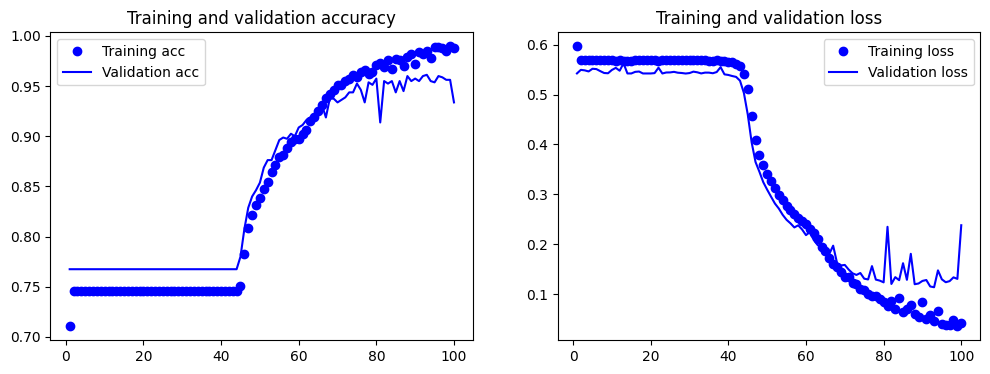

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the width (12) and height (4) as needed

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
axs[0].plot(epochs, acc, 'bo', label='Training acc')
axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, loss, 'bo', label='Training loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()

# Display the plots
plt.show()